Fetch Dataset from OpenML (Breast Cancer Wisconsin Data Set)

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
import pandas as pd

credit = fetch_openml("breast-w", version=1)
credit = credit.frame.dropna() # Remove rows with missing values
credit.sample(10)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
619,5.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,benign
88,4.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,benign
324,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,benign
83,3.0,1.0,1.0,1.0,2.0,2.0,7.0,1.0,1.0,benign
340,10.0,3.0,3.0,1.0,2.0,10.0,7.0,6.0,1.0,malignant
42,6.0,10.0,10.0,2.0,8.0,10.0,7.0,3.0,3.0,malignant
279,10.0,5.0,7.0,3.0,3.0,7.0,3.0,3.0,8.0,malignant
217,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,benign
24,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,benign
518,3.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,benign


Split Data Into Train and Testing Splits

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

# Separate and extract features (X) and target labels (y)
X = credit.drop('Class', axis=1)
y = credit['Class']

# Create train and test splits (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Default Decision Tree Classifier with Basic and 10-Fold CV Accuracy

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier() # Default DecisionTreeClassifier

clf.fit(X_train, y_train) # Training

y_pred = clf.predict(X_test) # Predictions

accuracy = accuracy_score(y_test, y_pred)
print(f"Standard Test Accuracy: {accuracy}")

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
print(f"10-fold Cross-Validation Accuracy: {scores.mean():.2f}")

Standard Test Accuracy: 0.9414634146341463
10-fold Cross-Validation Accuracy: 0.94


tune DecisionTreeClassifier Parameters using Sklearn's GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV

# Extensive Parameter Grid
param_grid = {
    'max_depth': range(1,16),
    'min_samples_split': range(2,8),
    'min_samples_leaf': range(2, 8),
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy') # 10-fold Cross Validation
grid_search.fit(X_train, y_train)

best_classifier = grid_search.best_estimator_

print(f"Best Hyperparameters: {grid_search.best_estimator_.get_params()}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Best Cross-Validation Accuracy: 0.96


Bias-Variance Trade-off Analysis

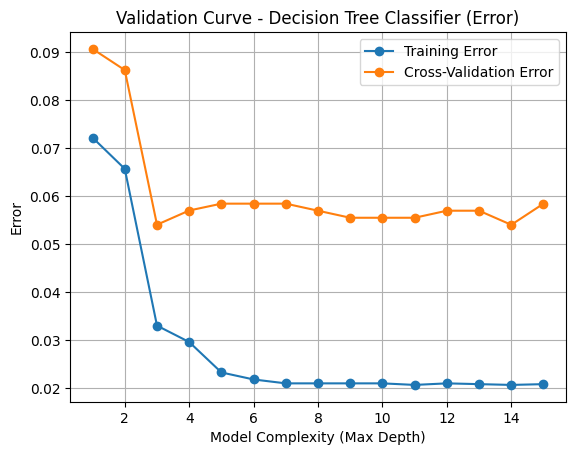

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import numpy as np

# MaxDepth as model complexity
param_range = range(1, 16)  # Explore depths from 1 to 15

# Validation Curve
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=2, criterion='entropy'),
    X, y, param_name="max_depth", param_range=param_range, cv=10, scoring="accuracy" # Same 10-Cross Fold Validation
)

# Calculate error (1 - accuracy) for train and test scores
train_errors_mean = 1 - train_scores.mean(axis=1)
test_errors_mean = 1 - test_scores.mean(axis=1)

# Create the plot
plt.plot(param_range, train_errors_mean, label='Training Error', marker='o')
plt.plot(param_range, test_errors_mean, label='Cross-Validation Error', marker='o')

plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Error')
plt.title('Validation Curve - Decision Tree Classifier (Error)')
plt.grid(True)
plt.legend()
plt.show()

Plotting Decision Tree

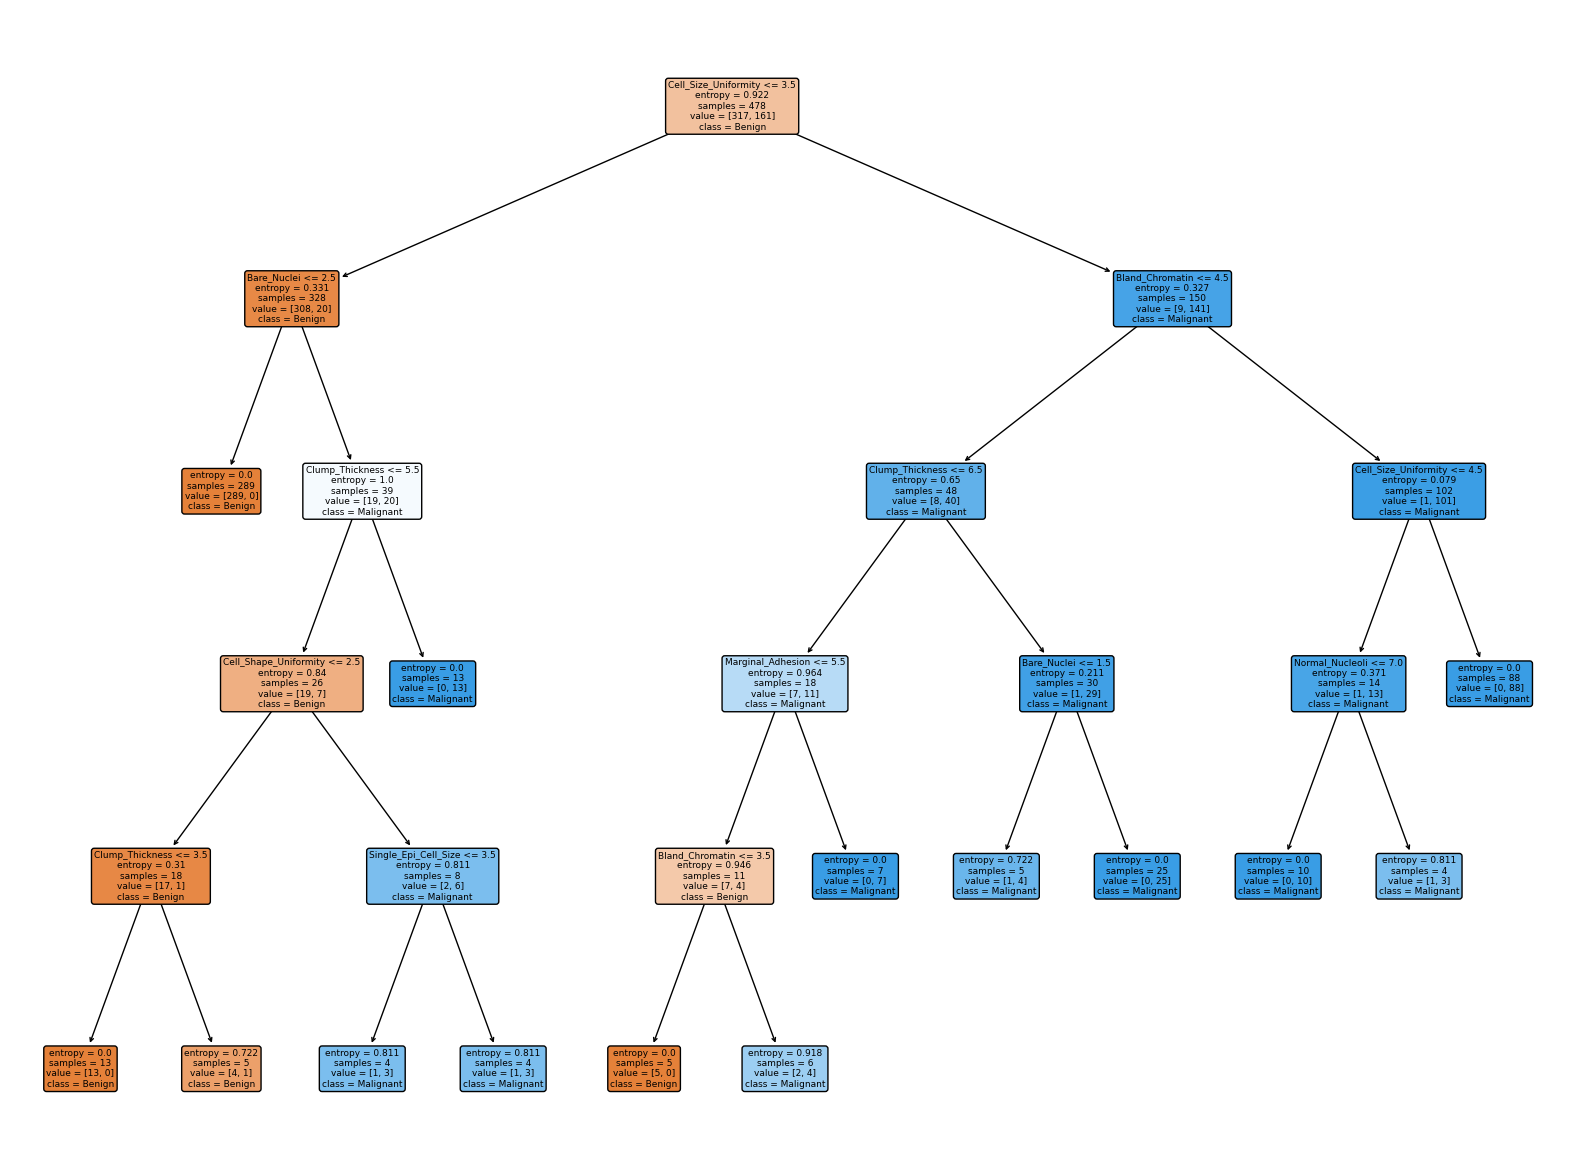

In [6]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 15))
plot_tree(best_classifier, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True, rounded=True)
plt.show()

Plotting Feature Importance

<Figure size 1500x1500 with 0 Axes>

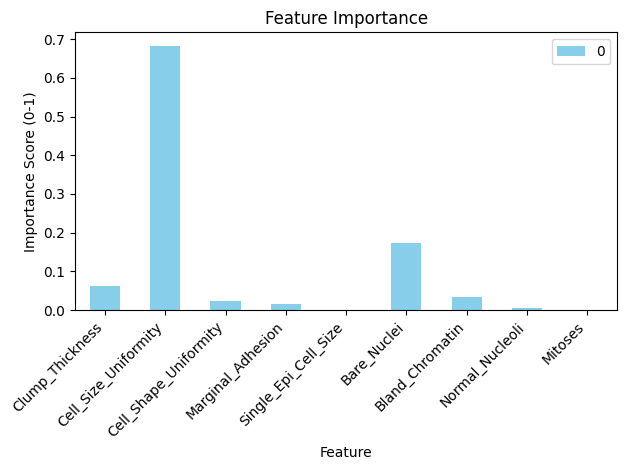

In [9]:
import pandas as pd

feature_importances = pd.DataFrame(best_classifier.feature_importances_, index = X.columns)

plt.figure(figsize=(15, 15))
feature_importances.plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score (0-1)')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to save space
plt.tight_layout()
plt.show()